In [ ]:
!pip install ucimlrepo

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
automobile = fetch_ucirepo(id=10)

# data (as pandas dataframes)
X = automobile.data.features
y = automobile.data.targets

# **PRE-PROCESSING OF THE DATA: TREAT MISSING VALUES**

**Continuous**: use mean of the group (price, peak-rpm, horsepower, stroke, bore, normalized-losses)

**Integer**: use mode (num of door)

In [ ]:
missing_cont = ['price', 'peak-rpm', 'horsepower', 'stroke', 'bore', 'normalized-losses']
for m in missing_cont:
  X[m] = X[m].fillna(X.groupby('make')[m].transform('mean'))
  #if none of the group has a value, substitute by overall mean
  X[m] = X[m].fillna(X[m].mean())

X['num-of-doors'] =  X['num-of-doors'].fillna(X.groupby('make')['num-of-doors'].transform())


<ipython-input-215-c7de2c436d73>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[m] = X[m].fillna(X.groupby('make')[m].transform('mean'))
<ipython-input-215-c7de2c436d73>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[m] = X[m].fillna(X[m].mean())
<ipython-input-215-c7de2c436d73>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

# **FIRST VISUALIZATION:** IS THERE A RELATION BETWEEN PRICE (AVG) AND BODY STYLE?

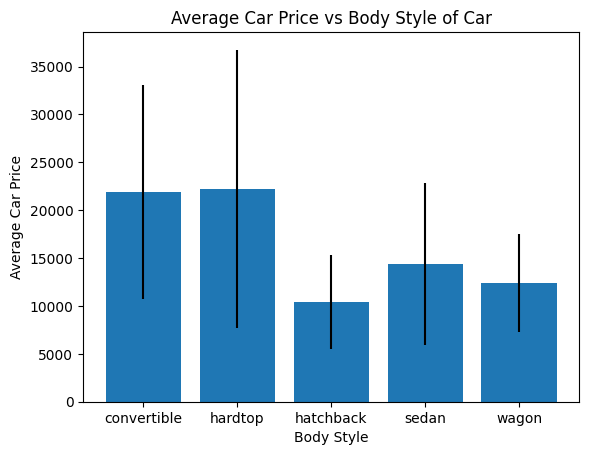

In [ ]:
means = X.groupby('body-style')['price'].mean()
stds = X.groupby('body-style')['price'].std()

plt.bar(means.index, means, yerr=stds)
plt.title("Average Car Price vs Body Style of Car")
plt.xlabel("Body Style")
plt.ylabel("Average Car Price")
plt.show()


**WHAT**: one quantitative value attribute (price mean) and one categorical key attribute (body style)

**HOW**: quantitative value in vertical axis and separate key attributes horizontally

**WHY**: compare values, in this case find if there is a relationship between the price and body style

**FINDINGS**: we can see that convertibles and hardtops have a higher price in average with respect to
the other cars, but there is also a very high variance in the car prices of these types. By analyzing the
data we see that the number of convertible and hardtop records is much lower than the records available
for the rest of body styles, which is what may cause such a high variance.


# **SECOND VISUALIZATION**: IS THERE A RELATION BETWEEN THE VOLUME OF A CAR AND ITS PRICE?

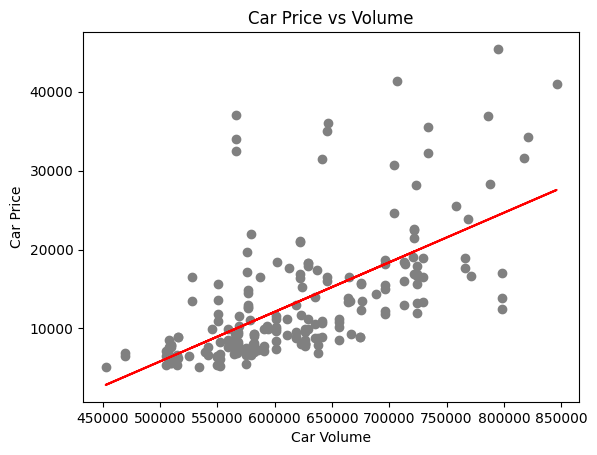

In [ ]:
X['volume'] = X['height']*X['width']*X['length']

reg = linear_model.LinearRegression()
reg.fit(X['volume'].values.reshape(-1,1), X['price'])
price_pred = reg.predict(X['volume'].values.reshape(-1,1))

plt.scatter(X['volume'], X['price'], color='grey')
plt.plot(X['volume'], price_pred, color='red')
plt.xlabel('Car Volume')
plt.ylabel('Car Price')
plt.title('Car Price vs Volume')
plt.show()

**WHAT**: two quantitative value attribute (price and volume)

**HOW**: one value in the vertical axis and the other in the horizontal axis with point marks

**WHY**: find out any trend, locate clusters, find outliers...

**FINDINGS**: we can see that there is a clear relation between the volume and price of a car, although it does not exactly follow a linear trend and we can see that as the volume increases the price value is further away from the line. This might mean that the relationship might follow other equation (e.g. it might be a quadratic relation).

# **THIRD VISUALIZATION**: BOXPLOT TO GATHER INFORMATION ABOUT MILES PER GALLON DATA

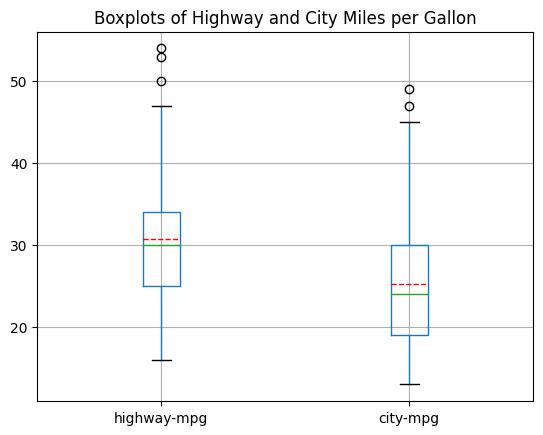

In [ ]:
X.boxplot(column=['highway-mpg',	'city-mpg'], meanline=True, showmeans=True, meanprops=dict(color='red'))
plt.title('Boxplots of Highway and City Miles per Gallon')
plt.show()

**WHAT**: many (two in our case, as they are in the same range) quantitative value attributes

**HOW**: five attributes for each quantitave attribute(median, quartiles, min and max)

**WHY**: to characterize its distribution

**FINDINGS**: the first thing we notice is that the median of highway mpg is higher than the one of the city. This does not come as a surprise, as the mpg is usually lower in cities since driving in cities necessitates slower speeds, idling and higher rpm. We can also see that in the case of highway mpg, the median is closer to the 75th percentile and in the city it is closer to the 25th percentile. We can also see that the upper whisker is longer in both cases, so this means there is more variability in the top 25% of the values. We can also see that there are some outliers in our data (outside 1.5xIQR).

# **FOURTH VISUALIZATION**: STACKED BAR CHART WITH SAFETY AND BODY STYLE INFORMATION

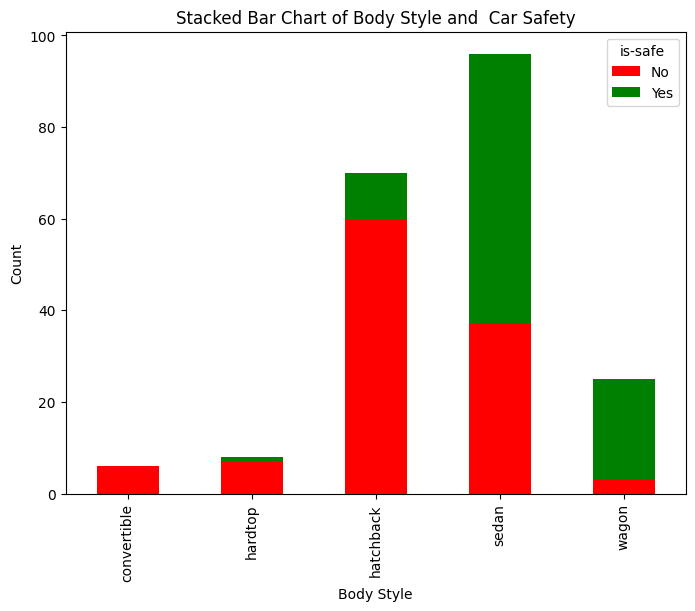

In [ ]:
X['is-safe'] = y['symboling'].apply(lambda x: 'Yes' if x < 1 else 'No')
bar_df = pd.DataFrame({'body-style':X['body-style'], 'is-safe':X['is-safe']})

count_data = bar_df.groupby(['body-style', 'is-safe']).size().unstack(fill_value=0)

count_data.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(8, 6))
plt.xlabel('Body Style')
plt.ylabel('Count')
plt.title('Stacked Bar Chart of Body Style and  Car Safety')
plt.legend(title='is-safe')
plt.show()

**WHAT**: quantitative value attributes (counts of Yes and No), categorical attribute (body style)

**HOW**: bar with different length subcomponents for each quantitative attribute and separate bars for each categorical attribute value

**WHY**: to find a trend or relation between both attributes

**FINDINGS**: we can clearly see a trend in which wagons are categorized more likely as safe than convertibles or hardtops. Sedans show a 50/50 distribution. We can also see that we have much less records of convertibles and hardtops than the rest of body styles. We will further study this in the next section.

# **FIFTH VISUALIZATION**: HEATMAP WITH BODY STYLE, NUMBER OF DOORS AND SYMBOLING (AVG)



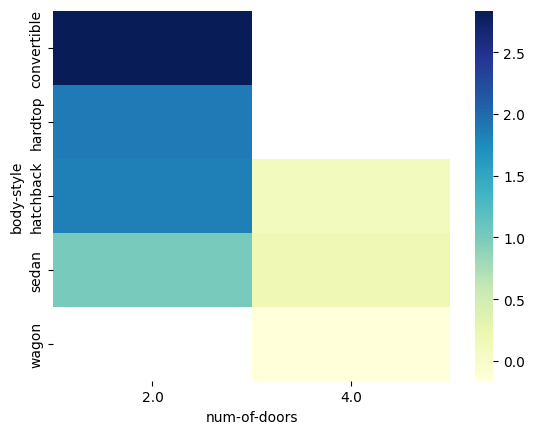

In [ ]:
heatmap_df = pd.DataFrame({"body-style": X['body-style'], "num-of-doors": X['num-of-doors'], "symboling": y['symboling']})
heatmap_data = heatmap_df.groupby(['body-style', 'num-of-doors']).agg('mean').reset_index()
heatmap_data = heatmap_data.pivot(index="body-style", columns="num-of-doors", values="symboling")

sns.heatmap(heatmap_data, cmap="YlGnBu")
plt.show()

**WHAT**: two categorical key attributes (number of doors and body-style) and one quantitative value attribute (average symboling or car risk)

**HOW**: 2D matrix of the categorical attributes and colormap for the value attribute

**WHY**: summarize and find a relation

**FINDINGS**: the main thing we notice is that cars with 2 doors are less safe than cars with 4 doors. We can also see that wagons would be the safest cars and convertibles the most unsafe. As it is obvious, we do not see any wagon with 2 doors or hardtop/convertibles with 4.